В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train.csv")
data.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [3]:
from sklearn.model_selection import train_test_split
target_col = 'Exited'

# Розділення даних на ознаки та цільову змінну
X = data.drop(target_col, axis=1)
y = data[target_col]

# Розбиття даних на тренувальний і валідаційний піднабори
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Об'єднання X та y назад у DataFrame для тренувального та валідаційного піднаборів
train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_val, y_val], axis=1)

# Перегляд розмірів отриманих піднаборів
print(f'Розмір тренувального набору: {train_data.shape}')
print(f'Розмір валідаційного набору: {val_data.shape}')

Розмір тренувального набору: (12000, 14)
Розмір валідаційного набору: (3000, 14)


2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [4]:
# Визначення вхідних колонок
input_cols = data.columns.drop(target_col)

# Розділення даних на ознаки (inputs) та цільову змінну (target)
X = data[input_cols]
y = data[target_col]

# Розбиття даних на тренувальний і валідаційний піднабори
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Створення піднаборів
train_inputs = X_train
train_targets = y_train
val_inputs = X_val
val_targets = y_val

# Перегляд розмірів отриманих піднаборів
print(f'Розмір train_inputs: {train_inputs.shape}')
print(f'Розмір train_targets: {train_targets.shape}')
print(f'Розмір val_inputs: {val_inputs.shape}')
print(f'Розмір val_targets: {val_targets.shape}')

Розмір train_inputs: (12000, 13)
Розмір train_targets: (12000,)
Розмір val_inputs: (3000, 13)
Розмір val_targets: (3000,)


3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [5]:
# Визначення числових колонок
numeric_cols = data.select_dtypes(include=['number']).columns.tolist()

# Визначення категоріальних колонок
categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()

# Виведення результатів
print("Числові колонки:", numeric_cols)
print("Категоріальні колонки:", categorical_cols)

Числові колонки: ['id', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
Категоріальні колонки: ['Surname', 'Geography', 'Gender']


4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Розділяємо на X та y
X = data.drop(columns=[target_col])  # Видаляємо цільову колонку з набору ознак X
y = data[target_col]

# Розбиваємо на тренувальні та валідаційні набори
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Визначаємо числові та категоріальні колонки з використанням X_train
numeric_cols = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Підготовка даних з використанням Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Підготовлені дані для тренувального та валідаційного наборів
train_inputs = preprocessor.fit_transform(X_train)
val_inputs = preprocessor.transform(X_val)

# Виведення перших 5 значень
pd.set_option('display.max_columns', None)

train_inputs_df = pd.DataFrame(train_inputs)
val_inputs_df = pd.DataFrame(val_inputs)

print("Train Inputs:")
display(train_inputs_df.head())

print("\nValidation Inputs:")
display(val_inputs_df.head())

Train Inputs:


,0
0,"(0, 0)\t-0.06913596317200911\n (0, 1)\t-0.2..."
1,"(0, 0)\t0.6722272274802016\n (0, 1)\t-0.666..."
2,"(0, 0)\t-1.7073801753197513\n (0, 1)\t0.569..."
3,"(0, 0)\t-0.949403803924634\n (0, 1)\t0.6101..."
4,"(0, 0)\t1.0974785067743267\n (0, 1)\t-0.332..."



Validation Inputs:


,0
0,"(0, 0)\t-0.22834561195819814\n (0, 1)\t0.70..."
1,"(0, 0)\t-0.884566251303012\n (0, 1)\t-0.500..."
2,"(0, 0)\t-0.5015401397304413\n (0, 1)\t0.660..."
3,"(0, 0)\t-1.575397683862215\n (0, 1)\t0.7653..."
4,"(0, 0)\t-1.1196889065394275\n (0, 1)\t0.554..."


5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [7]:
from scipy.sparse import csr_matrix  # Доданий імпорт
import os

# Підготовка даних з використанням Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Підготовка та перетворення даних для тренувального та валідаційного наборів
train_inputs = preprocessor.fit_transform(X_train)
val_inputs = preprocessor.transform(X_val)

train_targets = y_train.values.reshape(-1, 1)  # Перетворюємо у вектор стовпчика
val_targets = y_val.values.reshape(-1, 1)  # Перетворюємо у вектор стовпчика

# Конвертація розріджених матриць до плотних форматів
train_inputs_dense = train_inputs.toarray() if isinstance(train_inputs, csr_matrix) else train_inputs
val_inputs_dense = val_inputs.toarray() if isinstance(val_inputs, csr_matrix) else val_inputs

# Збереження даних у форматі Parquet
output_dir = "/content/drive/MyDrive/Colab Notebooks/processed_data"

# Створення директорії, якщо її ще не існує
os.makedirs(output_dir, exist_ok=True)

# Шляхи до файлів
train_inputs_file = os.path.join(output_dir, 'train_inputs.parquet')
train_targets_file = os.path.join(output_dir, 'train_targets.parquet')
val_inputs_file = os.path.join(output_dir, 'val_inputs.parquet')
val_targets_file = os.path.join(output_dir, 'val_targets.parquet')

# Збереження у форматі Parquet
pd.DataFrame(train_inputs_dense).to_parquet(train_inputs_file, index=False)
pd.DataFrame(train_targets).to_parquet(train_targets_file, index=False)
pd.DataFrame(val_inputs_dense).to_parquet(val_inputs_file, index=False)
pd.DataFrame(val_targets).to_parquet(val_targets_file, index=False)

# Виведення списку файлів у директорії
files = os.listdir(output_dir)
print("Список файлів у директорії:")
print(files)

Список файлів у директорії:
['train_inputs.parquet', 'train_targets.parquet', 'val_inputs.parquet', 'val_targets.parquet']


6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Навчання моделі Logistic Regression
model = LogisticRegression(random_state=42)
model.fit(train_inputs, train_targets.ravel())  # train_targets має бути вектором розмірності (n_samples,)

# Прогнозування на валідаційному наборі
val_predictions = model.predict_proba(val_inputs)[:, 1]  # вибираємо ймовірності позитивного класу

# Оцінка моделі за допомогою ROC AUC
roc_auc = roc_auc_score(val_targets, val_predictions)
print(f'ROC AUC на валідаційному наборі: {roc_auc:.4f}')

ROC AUC на валідаційному наборі: 0.8845


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

Confusion Matrix для тренувальних даних:
[[9189  369]
 [1021 1421]]


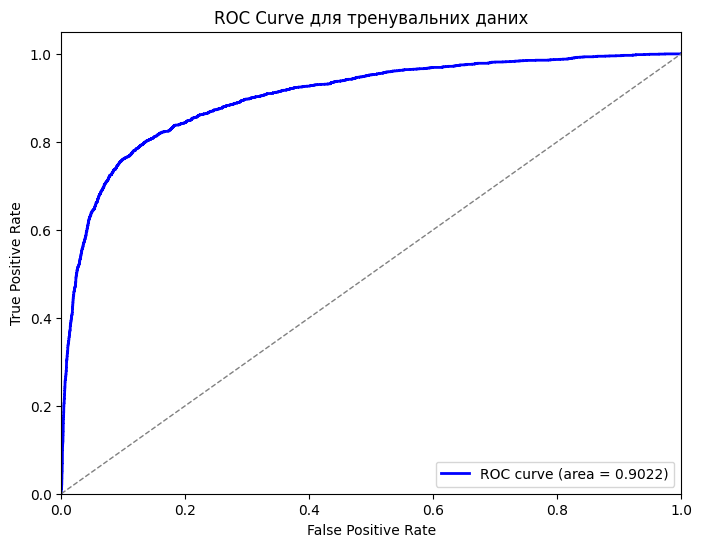

AUROC для тренувальних даних: 0.9022
F1 Score для тренувальних даних (threshold = 0.5): 0.6716


In [9]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Прогнозування класів на тренувальному наборі
train_pred = model.predict(train_inputs)

# Прогнозування ймовірностей для позитивного класу на тренувальному наборі
train_pred_proba = model.predict_proba(train_inputs)[:, 1]

# Confusion Matrix
cm_train = confusion_matrix(train_targets, train_pred)
print("Confusion Matrix для тренувальних даних:")
print(cm_train)

# ROC Curve
fpr_train, tpr_train, thresholds_train = roc_curve(train_targets, train_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='ROC curve (area = %0.4f)' % roc_auc_score(train_targets, train_pred_proba))
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve для тренувальних даних')
plt.legend(loc="lower right")
plt.show()

# AUROC
auroc_train = roc_auc_score(train_targets, train_pred_proba)
print(f'AUROC для тренувальних даних: {auroc_train:.4f}')

# F1 Score для порога класифікації 0.5
threshold = 0.5
train_pred_binary = (train_pred_proba >= threshold).astype(int)
f1_train = f1_score(train_targets, train_pred_binary)
print(f'F1 Score для тренувальних даних (threshold = {threshold}): {f1_train:.4f}')

Confusion Matrix для валідаційних даних:
[[2259  131]
 [ 254  356]]


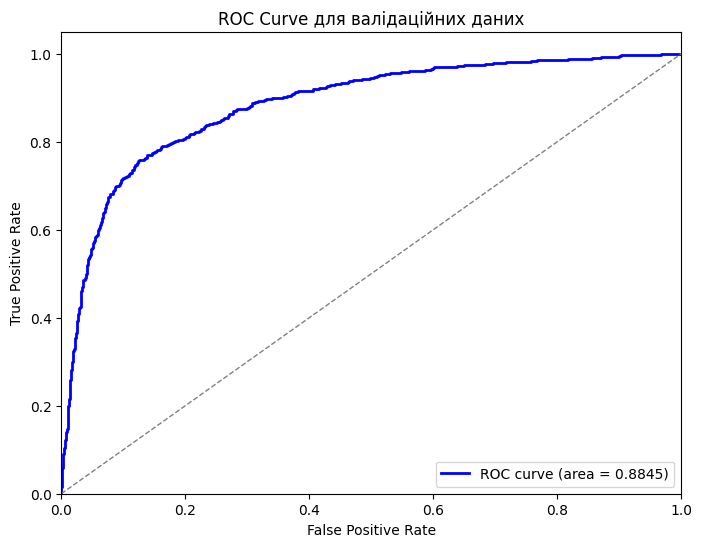

AUROC для валідаційних даних: 0.8845
F1 Score для валідаційних даних (threshold = 0.5): 0.6490


In [10]:
# Прогнозування класів на валідаційному наборі
val_pred = model.predict(val_inputs)

# Прогнозування ймовірностей для позитивного класу на валідаційному наборі
val_pred_proba = model.predict_proba(val_inputs)[:, 1]

# Confusion Matrix
cm_val = confusion_matrix(val_targets, val_pred)
print("Confusion Matrix для валідаційних даних:")
print(cm_val)

# ROC Curve
fpr_val, tpr_val, thresholds_val = roc_curve(val_targets, val_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_val, tpr_val, color='blue', lw=2, label='ROC curve (area = %0.4f)' % roc_auc_score(val_targets, val_pred_proba))
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve для валідаційних даних')
plt.legend(loc="lower right")
plt.show()

# AUROC
auroc_val = roc_auc_score(val_targets, val_pred_proba)
print(f'AUROC для валідаційних даних: {auroc_val:.4f}')

# F1 Score для порога класифікації 0.5
val_pred_binary = (val_pred_proba >= threshold).astype(int)
f1_val = f1_score(val_targets, val_pred_binary)
print(f'F1 Score для валідаційних даних (threshold = {threshold}): {f1_val:.4f}')

AUROC:
Для тренувальних даних: 0.9022
Для валідаційних даних: 0.8845
AUROC вказує на якість моделі в розділенні класів. Високе значення AUROC, близьке до 1, свідчить про те, що модель добре розділяє класи навіть на нових, валідаційних даних. У нашому випадку обидва значення (близько 0.90) є досить високими, що говорить про добру загальну ефективність моделі.

F1 Score для порога класифікації 0.5:
Для тренувальних даних: 0.6716
Для валідаційних даних: 0.6490
F1 Score є гармонічним середнім між точністю і чутливістю моделі. Високе значення F1 Score також свідчить про те, що модель добре працює з даними. У нашому випадку значення F1 Score близьке до 0.65 на валідаційних даних є досить хорошим результатом, особливо при розгляді того, що деякі задачі можуть мати вищу або нижчу вимогу до точності.

Отже, модель логістичної регресії, побудована для цієї задачі, показує досить добрі результати з точки зору метрик AUROC і F1 Score на тренувальних і валідаційних даних. AUROC навіть на валідаційних даних залишається високим, що свідчить про стабільність моделі. F1 Score також демонструє хорошу збалансованість між точністю і чутливістю.

Отже, модель можна вважати хорошою для цієї задачі класифікації, адже вона демонструє стабільність і достатню точність на тренувальних і валідаційних наборах даних.

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [11]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Ініціалізація DummyClassifier, що передбачає завжди мажоритарний клас
dummy_clf = DummyClassifier(strategy='most_frequent')

# Навчання моделі на тренувальних даних
dummy_clf.fit(train_inputs, train_targets)

# Прогнозування на тренувальних даних
train_pred_dummy = dummy_clf.predict(train_inputs)

# Прогнозування на валідаційних даних
val_pred_dummy = dummy_clf.predict(val_inputs)

# Обчислення Accuracy для тренувальних і валідаційних даних
accuracy_train_dummy = accuracy_score(train_targets, train_pred_dummy)
accuracy_val_dummy = accuracy_score(val_targets, val_pred_dummy)

print(f'Accuracy для моделі Dummy (мажоритарний клас) на тренувальних даних: {accuracy_train_dummy:.4f}')
print(f'Accuracy для моделі Dummy (мажоритарний клас) на валідаційних даних: {accuracy_val_dummy:.4f}')

# Прогнозування на тренувальних даних (вже є з попереднього розділу)
train_pred = model.predict(train_inputs)

# Прогнозування на валідаційних даних (вже є з попереднього розділу)
val_pred = model.predict(val_inputs)

# Обчислення Accuracy для тренувальних і валідаційних даних
accuracy_train_model = accuracy_score(train_targets, train_pred)
accuracy_val_model = accuracy_score(val_targets, val_pred)

print(f'Accuracy для моделі Logistic Regression на тренувальних даних: {accuracy_train_model:.4f}')
print(f'Accuracy для моделі Logistic Regression на валідаційних даних: {accuracy_val_model:.4f}')

Accuracy для моделі Dummy (мажоритарний клас) на тренувальних даних: 0.7965
Accuracy для моделі Dummy (мажоритарний клас) на валідаційних даних: 0.7967
Accuracy для моделі Logistic Regression на тренувальних даних: 0.8842
Accuracy для моделі Logistic Regression на валідаційних даних: 0.8717


Модель Dummy (мажоритарний клас) має нижчу Accuracy порівняно з логістичною регресією на обох наборах даних (тренувальних і валідаційних). Це свідчить про те, що проста модель, яка просто передбачає завжди мажоритарний клас (в даному випадку, ймовірно, клас "0"), є менш ефективною у класифікації.

Логістична регресія, натренована на даних, показує кращі результати з точки зору Accuracy на обох наборах даних. Це свідчить про те, що модель здатна краще адаптуватися до навчальних даних і здійснювати більш точні прогнози на нових, валідаційних даних.

Отже, з точки зору Accuracy, логістична регресія показує кращі результати і може бути використана для подальшого застосування в задачі класифікації, оскільки вона здатна досягати більш високої точності порівняно з простою базовою моделлю (моделью Dummy).

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import joblib

# Припустимо, що у нас є натренована модель `model`, стандартизатор `scaler`
# і список колонок, які використовувались для тренування моделі `input_cols`

# Ініціалізуємо модель логістичної регресії та стандартизатор
model = LogisticRegression()
scaler = StandardScaler(with_mean=False)  # Встановлюємо with_mean=False для роботи з розрідженими даними

# Припустимо, що `train_inputs` є вхідними даними, які використовувались для тренування

# Перед тренуванням моделі потрібно відповідно підготувати дані, використовуючи scaler
train_inputs_scaled = scaler.fit_transform(train_inputs)

# Тренування моделі на підготовлених даних
model.fit(train_inputs_scaled, train_targets)

# Збереження моделі, стандартизатора та інших важливих об'єктів
joblib.dump({
    'model': model,
    'scaler': scaler,
    'input_columns': input_cols  # Наприклад, список колонок, які використовувались для тренування моделі
}, 'log_reg.joblib')

# Завантаження моделі та інших об'єктів з файлу
loaded_objects = joblib.load('log_reg.joblib')
model_2 = loaded_objects['model']
scaler_2 = loaded_objects['scaler']
input_cols_2 = loaded_objects['input_columns']

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [16]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    prob = model.predict_proba(X_input)[:,1]
    return prob

In [24]:
import joblib

# Ініціалізація стандартизатора та кодувальника
scaler = StandardScaler(with_mean=False)
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Підготовка тренувальних даних
train_inputs = X_train.copy()
train_targets = y_train

# Перетворення числових колонок на числовий тип
train_inputs[numeric_cols] = train_inputs[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Масштабування числових колонок
train_inputs[numeric_cols] = scaler.fit_transform(train_inputs[numeric_cols])

# Кодування категоріальних колонок
encoded_array = encoder.fit_transform(train_inputs[categorical_cols])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_cols), index=train_inputs.index)

# Об'єднання числових та закодованих категоріальних колонок
train_inputs_prepared = pd.concat([train_inputs[numeric_cols], encoded_df], axis=1)

# Ініціалізація та тренування моделі
model = LogisticRegression()
model.fit(train_inputs_prepared, train_targets)

# Збереження моделі, стандартизатора та інших важливих об'єктів
joblib.dump({
    'model': model,
    'scaler': scaler,
    'encoder': encoder,
    'input_columns': input_cols,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_feature_names': encoder.get_feature_names_out(categorical_cols)
}, 'log_reg.joblib')

# Функція для передбачення
def predict_raw_df(model, scaler, encoder, numeric_cols, categorical_cols, encoded_feature_names, input_df: pd.DataFrame):
    # Перетворення числових колонок на числовий тип
    input_df[numeric_cols] = input_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

    # Масштабування числових колонок
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])

    # Кодування категоріальних колонок
    encoded_array = encoder.transform(input_df[categorical_cols])
    encoded_df = pd.DataFrame(encoded_array, columns=encoded_feature_names, index=input_df.index)

    # Об'єднання числових та закодованих категоріальних колонок
    X_input = pd.concat([input_df[numeric_cols], encoded_df], axis=1)

    # Перевірка відповідності кількості ознак
    assert X_input.shape[1] == model.coef_.shape[1], "Number of features does not match training data."

    # Отримання ймовірностей належності до класу 1
    prob = model.predict_proba(X_input)[:, 1]

    return prob

# Завантаження моделі та інших об'єктів з файлу
loaded_objects = joblib.load('log_reg.joblib')
model = loaded_objects['model']
scaler = loaded_objects['scaler']
encoder = loaded_objects['encoder']
input_cols = loaded_objects['input_columns']
numeric_cols = loaded_objects['numeric_cols']
categorical_cols = loaded_objects['categorical_cols']
encoded_feature_names = loaded_objects['encoded_feature_names']

# Використання функції для передбачень
probabilities = predict_raw_df(model, scaler, encoder, numeric_cols, categorical_cols, encoded_feature_names, X_val[:5])
print(probabilities)

[0.00809814 0.03430155 0.05005231 0.2201292  0.06678297]


11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [41]:
import pandas as pd
import joblib

# Завантаження моделі та інших об'єктів з файлу
loaded_objects = joblib.load('log_reg.joblib')
model = loaded_objects['model']
scaler = loaded_objects['scaler']
encoder = loaded_objects['encoder']
encoded_feature_names = loaded_objects['encoded_feature_names']
numeric_cols = loaded_objects['numeric_cols']
categorical_cols = loaded_objects['categorical_cols']

# Функція для передбачення з оновленням test_raw_df
def predict_and_update(df, model, scaler, encoder, numeric_cols, categorical_cols, encoded_feature_names):
    # Перетворення числових колонок на числовий тип (якщо необхідно)
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

    # Масштабування числових колонок
    df[numeric_cols] = scaler.transform(df[numeric_cols])

    # Кодування категоріальних колонок
    encoded_array = encoder.transform(df[categorical_cols])
    encoded_df = pd.DataFrame(encoded_array, columns=encoded_feature_names, index=df.index)

    # Об'єднання числових та закодованих категоріальних колонок
    X_input = pd.concat([df[numeric_cols], encoded_df], axis=1)

    # Передбачення ймовірностей
    probabilities = model.predict_proba(X_input)[:, 1]

    # Запис результатів передбачення в нову колонку 'Exited'
    df['Exited'] = probabilities

    return df

# Завантаження тестових даних з test.csv
test_raw_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test.csv")

# Виклик функції для передбачення і оновлення test_raw_df
test_raw_df = predict_and_update(test_raw_df, model, scaler, encoder, numeric_cols, categorical_cols, encoded_feature_names)

# Збереження оновленого test_raw_df з результатами передбачень
test_raw_df.to_csv("/content/drive/MyDrive/Colab Notebooks/test_predicted.csv", index=False)

# Виведення перших кількох рядків з оновленими даними
test_raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,3.461079,106.141310,Chu,8.073893,Germany,Male,3.686364,0.718944,2.438123,1.877497,2.456576,2.000283,3.463484,0.058437
1,3.461310,106.468178,Mazzi,7.617663,France,Male,4.792273,1.797360,0.000000,3.754995,2.456576,2.000283,1.479159,0.035546
2,3.461541,106.968182,Onyekachi,9.760563,France,Male,5.283788,2.875775,0.000000,3.754995,2.456576,0.000000,3.438841,0.139504
3,3.461772,107.436407,Martin,9.912639,Spain,Male,5.529546,1.078416,0.000000,1.877497,2.456576,2.000283,3.661301,0.174886
4,3.462002,106.605214,Kenechukwu,8.184495,Spain,Male,5.283788,2.875775,0.000000,3.754995,2.456576,2.000283,3.151778,0.034157


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [46]:
import pandas as pd
import joblib

# Завантаження навченої моделі та інших об'єктів з файлу
loaded_objects = joblib.load('log_reg.joblib')
model = loaded_objects['model']
scaler = loaded_objects['scaler']
encoder = loaded_objects['encoder']
encoded_feature_names = loaded_objects['encoded_feature_names']
numeric_cols = loaded_objects['numeric_cols']
categorical_cols = loaded_objects['categorical_cols']

# Зчитування файлу 'sample_submission.csv'
submission_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/sample_submission.csv")

# Відокремлення ідентифікаторів клієнтів для передбачення
client_ids = submission_df['id']

# Підготовка даних для передбачення (тут можуть бути потрібні додаткові перетворення)
# Наприклад, масштабування числових колонок і кодування категоріальних

# Приклад підготовки даних (потрібно адаптувати до вашого випадку)
test_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test.csv")
test_numeric = test_data[numeric_cols].copy()
test_categorical = test_data[categorical_cols].copy()

# Масштабування числових колонок
test_numeric_scaled = scaler.transform(test_numeric)

# Кодування категоріальних колонок
test_encoded = encoder.transform(test_categorical)
test_encoded_df = pd.DataFrame(test_encoded, columns=encoded_feature_names, index=test_categorical.index)

# Об'єднання числових та закодованих категоріальних колонок для тестувального набору
X_test = pd.concat([pd.DataFrame(test_numeric_scaled, columns=numeric_cols), test_encoded_df], axis=1)

# Передбачення ймовірностей відтоку для тестового набору
probabilities = model.predict_proba(X_test)[:, 1]

# Запис передбачень у колонку 'Exited' у відповідність до клієнтів за їхніми ідентифікаторами
submission_df['Exited'] = probabilities

# Збереження результату у файл CSV без індексів рядків
submission_df.to_csv('submission_log_reg.csv', index=False)

# Виведення перших 5 рядків збереженого файлу для перевірки
submission_df.head()

,id,Exited
0,15000,0.058437
1,15001,0.035546
2,15002,0.139504
3,15003,0.174886
4,15004,0.034157


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['id'].plot(kind='hist', bins=20, title='id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Exited'].plot(kind='hist', bins=20, title='Exited')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='index', y='id', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='id', y='Exited', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Exited']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Exited')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['id']
  ys = series['Exited']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
_ = plt.ylabel('Exited')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'id'}, axis=1)
              .sort_values('id', ascending=True))
  xs = counted['id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_9['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['id'].plot(kind='line', figsize=(8, 4), title='id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['Exited'].plot(kind='line', figsize=(8, 4), title='Exited')
plt.gca().spines[['top', 'right']].set_visible(False)

In [47]:
import os

# Перевірити список файлів у поточному каталозі
files_in_current_directory = os.listdir('/content/')
print(files_in_current_directory)

['.config', 'log_reg.joblib', 'drive', 'submission_log_reg.csv', 'sample_data']
